In [1]:
# import necessary packages
import os, sys, glob
import math
import time
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch

from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from PIL import Image
from importlib import reload # when you make changes to a .py, force reload imports
from DGXutils import GetFileNames, GetLowestGPU

# custom imports
sys.path.append('../')

from utils.GetLR import get_lr
import utils.Train as Train
import utils.Plot as Plot
import utils.WeightedCrossEntropy as WeightedCrossEntropy
import utils.BuildUNet as BuildUNet
import utils.TileGenerator as TG
import utils.DistanceMap as DistanceMap

device = torch.device(GetLowestGPU(verbose=2))

cuda:0   519MiB / 40960MiB
cuda:1   519MiB / 40960MiB
cuda:2   519MiB / 40960MiB
cuda:3   519MiB / 40960MiB
cuda:4   519MiB / 40960MiB
cuda:5   519MiB / 40960MiB
cuda:6   519MiB / 40960MiB
cuda:7   519MiB / 40960MiB

Device set to: cuda:0


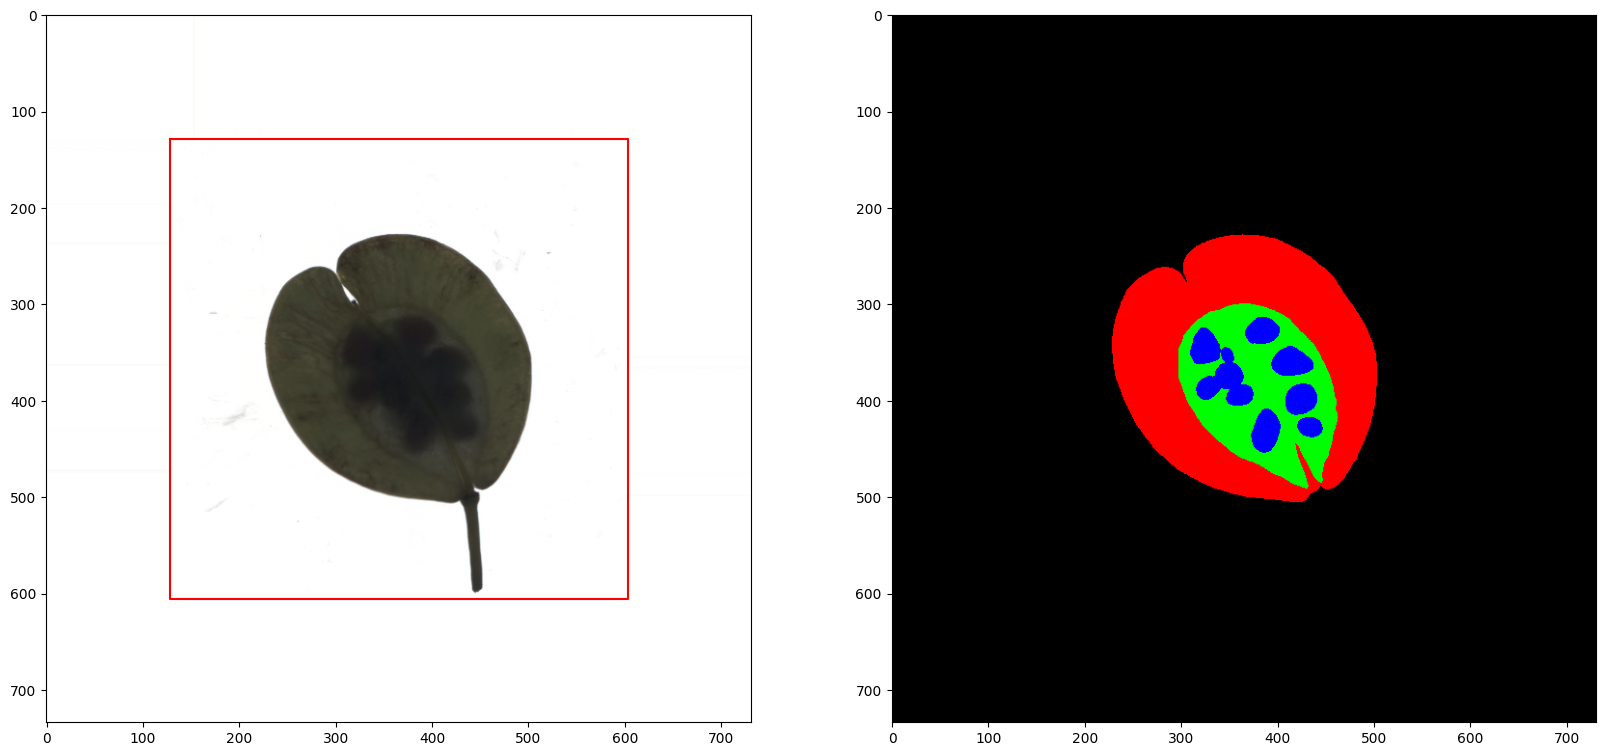

In [4]:
# define options
img_path = '../data/train/train_images_by_pod/'
mask_path = '../data/train/train_masks_by_pod/'

# load images and masks into list
img_names = GetFileNames(img_path,
                           extension=".png")
mask_names = GetFileNames(mask_path,
                            extension=".png")

# supervised and unsupervised images
s_images = []
u_images = []
masks = []
n_pad = 128   # padding for images

# VISUALIZE
for img_name in img_names:

    # load image
    image = np.array(Image.open(img_path + img_name))
    image = (image[:, :, :3] / 255.0) # normalize image
    image = np.pad(image, ((n_pad, n_pad), (n_pad, n_pad), (0, 0)), 'edge') # pad image w/ values on edge

    if img_name in mask_names:
        # load mask
        mask = np.array(Image.open(mask_path + img_name))
        mask = (mask / 255.0) # normalize mask
        mask = np.pad(mask, ((n_pad, n_pad), (n_pad, n_pad), (0, 0)), 'constant', constant_values=0) # pad mask w/ constant 0 value
        masks.append(mask)
        s_images.append(image)
    else:
        u_images.append(image)

# split masks into wing and pod and seed
wings = [m[:, :, 0] > 0.5 for m in masks] # take red channel and booleanize
envelopes = [m[:, :, 1:].sum(-1) > 0.5 for m in masks] # "... blue ..."
seeds = [m[:, :, 2] > 0.5 for m in masks] # "... green ..."

# create list for multiclass masks
multiclass_masks = []

# add additional channel to pennycress masks for one-hot encoding
for mask in masks:
    bg = mask.sum(-1) == 0 # booleanize background
    mask = np.concatenate([bg.reshape(*bg.shape, 1), mask], axis=-1) # add background channel
    multiclass_masks.append(mask)

# plot images and masks
i = np.random.randint(0, len(s_images)) #select random from list of pennycress images
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(s_images[i])
# plot line around padding
ax[0].plot([n_pad, n_pad, s_images[i].shape[1] - n_pad, s_images[i].shape[1] - n_pad, n_pad],
           [n_pad, s_images[i].shape[0] - n_pad, s_images[i].shape[0] - n_pad, n_pad, n_pad], 'r')
ax[1].imshow(masks[i])
plt.tight_layout
plt.show()

281

In [5]:
# whenever you run cell, re-import TG as a module
reload(TG)
reload(DistanceMap)

# options
masks = multiclass_masks
tile_size = 128
train_prop = 0.8
distance_weights = True

#create train/val splits by image for supervised and unsupervised
p = np.random.permutation(len(s_images))
s_train_idx = p[:int(train_prop*len(s_images))]
s_val_idx = p[int(train_prop*len(s_images)):]

p = np.random.permutation(len(u_images))
u_train_idx = p[:int(train_prop*len(u_images))]
u_val_idx = p[int(train_prop*len(u_images)):]

# supervised
s_train_generator = TG.TileGenerator(
    images=[s_images[i] for i in s_train_idx],
    masks=[masks[i] for i in s_train_idx], 
    tile_size=tile_size, 
    split='train',
    n_pad = n_pad,
    distance_weights=True
    )

s_val_generator = TG.TileGenerator(
    images=[s_images[i] for i in s_val_idx],
    masks=[masks[i] for i in s_val_idx], 
    tile_size=tile_size, 
    split='val',
    n_pad = n_pad,
    distance_weights=True
    )

# unsupervised
u_train_generator = TG.WNetTileGenerator(
    images=[u_images[i] for i in u_train_idx],
    tile_size=tile_size, 
    split='train',
    n_pad = n_pad
    )

u_val_generator = TG.WNetTileGenerator(
    images=[u_images[i] for i in u_val_idx],
    tile_size=tile_size, 
    split='val',
    n_pad = n_pad
    )

#plot random samples
figsize = 15
np.random.seed(0)
    
print('Plotting training examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(s_train_generator)
for i in range(8):
    rand_idx = np.random.choice(N)

    if distance_weights:
        img, t = s_train_generator[rand_idx]
        img = img.permute(1, 2, 0).numpy()
        msk = t[:-1, :, :].permute(1, 2, 0).numpy()[:, :, 1:]
        w = t[-1, :, :].numpy()

        ax = fig.add_subplot(4, 6, 3*i+1)
        plt.imshow(img, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 6, 3*i+2)
        plt.imshow(msk)
        ax = fig.add_subplot(4, 6, 3*i+3)
        plt.imshow(w); plt.colorbar()

    else:
        img, msk = s_train_generator[rand_idx]
        img = img.permute(1, 2, 0).numpy()
        msk = msk.permute(1, 2, 0).numpy()[:, :, 1:]
        
        ax = fig.add_subplot(4, 4, 2*i+1)
        plt.imshow(img, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 4, 2*i+2)
        plt.imshow(msk, vmin=0, vmax=1)

plt.tight_layout(pad=0.5)
plt.show()

print('Plotting validation examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(s_val_generator)
for i in range(8):
    rand_idx = np.random.choice(N)

    if distance_weights:

        # get supervised image and mask
        img, t = s_val_generator[rand_idx]
        img = img.permute(1, 2, 0).numpy()
        msk = t[:-1, :, :].permute(1, 2, 0).numpy()[:, :, 1:]
        w = t[-1, :, :].numpy()

        ax = fig.add_subplot(4, 6, 3*i+1)
        plt.imshow(img, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 6, 3*i+2)
        plt.imshow(msk, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 6, 3*i+3)
        plt.imshow(w); plt.colorbar()

    else:
        img, msk = s_val_generator[rand_idx]
        img = img.permute(1, 2, 0).numpy()
        msk = msk.permute(1, 2, 0).numpy()[:, :, 1:]

        ax = fig.add_subplot(4, 4, 2*i+1)
        plt.imshow(img, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 4, 2*i+2)
        plt.imshow(msk, vmin=0, vmax=1)

plt.tight_layout(pad=0.5)
plt.show()

ValueError: need at least one array to concatenate